# 设定：
使用class0的三天数据，预测class0的七天数据

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def mape_loss_func(preds, labels):
    mask = labels > 5
    return np.mean(np.fabs(labels[mask]-preds[mask])/labels[mask])

def smape_loss_func(preds, labels):
    mask= labels > 5
    return np.mean(2*np.fabs(labels[mask]-preds[mask])/(np.fabs(labels[mask])+np.fabs(preds[mask])))

def mae_loss_func(preds, labels):
    mask= labels > 5
    return np.fabs((labels[mask]-preds[mask])).mean()

def eliminate_nan(b):
    a = np.array(b)
    c = a[~np.isnan(a)]
    return c

# Load data

In [3]:
randseed = 25
res = 11

v = pd.read_csv('../data/v_20_aggragated.csv')
v = v.rename(columns={'Unnamed: 0': 'id'})
det_with_class = pd.read_csv('../res/%i_res%i_id_402_withclass.csv'%(randseed, res), index_col=0)

v['class_i'] = ''
for i in range(len(v)):
    v.loc[i, 'class_i'] = det_with_class[det_with_class['id']==v.loc[i, 'id']].iloc[0, 5]  # 5 stands for 'class_i'

num_class = det_with_class['class_i'].drop_duplicates().size

v_class = []
for i in range(num_class):
    v_class.append(v[v['class_i']==i])

print('There are %i class(es)'%num_class)

dist_mat = pd.read_csv('../data/dist_mat.csv', index_col=0)
id_info = pd.read_csv('../data/id2000.csv', index_col=0)
dist_mat.index = id_info['id2']
dist_mat.columns = id_info['id2']
for i in range(len(dist_mat)):
    for j in range(len(dist_mat)):
        if i==j:
            dist_mat.iloc[i, j] = 0

near_id = pd.DataFrame(np.argsort(np.array(dist_mat)), index = id_info['id2'], columns = id_info['id2'])

def get_node(det, seg):
    # det is one single detector id
    # node is one single node id
    
    # seg = pd.read_csv('./data/segement.csv', header=None)
    try:
        node_info = seg[seg[6]==det]
        node = node_info.iloc[0, 0]
    except:
        node_info = seg[seg[7]==det]
        node = node_info.iloc[0, 0]
        
    return node

def get_class_with_node(seg, v_class):
    det_list_class = np.array([])
    try:
        v_class.insert(1, 'id2', '')  # id2 mean node id
    except:
        v_class['id2'] = ''
        
    for i in range(len(v_class)):
        det_list_class = np.append(det_list_class, v_class.iloc[i, 0])
        v_class.iloc[i, 1] = get_node(v_class.iloc[i, 0], seg)
    
    return det_list_class, v_class

def rds_mat(old_dist_mat, det_ids):
    # get a matrix that contains n raods that have specified node id s
    node_ids = np.array([])
    for i in det_ids:
        node_ids = np.append(node_ids, get_node(i, seg))
        
    new_dist_mat = old_dist_mat.loc[node_ids, node_ids]
    old_dist_mat = np.array(old_dist_mat)
    new_near_id_mat = np.argsort(new_dist_mat)
    return new_near_id_mat

seg = pd.read_csv('../data/segement.csv', header=None)
num_dets = 30

det_list_class = []
for i in range(num_class):
    det_list_class_temp, v_class_temp = get_class_with_node(seg, v_class[i])
    det_list_class.append(det_list_class_temp)
    v_class_temp = v_class_temp[v_class_temp['id'].isin(det_list_class_temp[:num_dets])]
    v_class[i] = v_class_temp

near_road_set = []
for i in range(num_class):
    near_road_set.append(rds_mat(dist_mat, det_list_class[i][:num_dets]))



There are 5 class(es)


/opt/anaconda3/envs/dan_traff/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


# 用前三天的数据取平均，得到之后数据的预测值

In [4]:
v_his1 = np.array(v_class[0].iloc[:, 4466-144*10-1:4466-144*9-1])
v_his2 = np.array(v_class[0].iloc[:, 4466-144*9-1:4466-144*8-1])
v_his3 = np.array(v_class[0].iloc[:, 4466-144*8-1:4466-144*7-1])

In [5]:
v_pre = (v_his1+v_his2+v_his3)/3
print(v_pre.shape)

(30, 144)


In [6]:
v_pre = np.concatenate((v_pre, v_pre, v_pre, v_pre, v_pre, v_pre), axis=1)
v_pre.shape

(30, 864)

In [7]:
label = np.array(v_class[0].iloc[:, 4466-144*7-1:4466-144-1])
print(label.shape)

(30, 864)


In [8]:
mape = mape_loss_func(v_pre, label)
print(mape)

0.1805941016596768


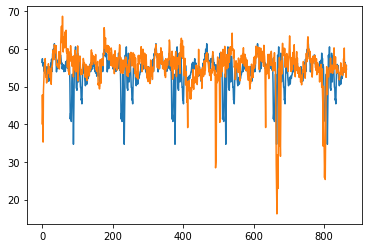

In [9]:
plt.plot(v_pre[0, :])
plt.plot(label[0, :])